In [3]:
from __future__ import division
from builtins import map
import numpy

try:
    # If you use vigra, we do special handling to preserve axistags
    import vigra
    _vigra_available = True
except ImportError:
    _vigra_available = False

def blockwise_view(a, blockshape, aslist=False, require_aligned_blocks=True ):
    """
    Return a 2N-D view of the given N-D array, rearranged so each ND block (tile) 
    of the original array is indexed by its block address using the first N 
    indexes of the output array.
    
    Note: This function is nearly identical to ``skimage.util.view_as_blocks()``, except:
          - "imperfect" block shapes are permitted (via require_aligned_blocks=False)
          - only contiguous arrays are accepted.  (This function will NOT silently copy your array.)
            As a result, the return value is *always* a view of the input.
    
    Args:
        a: The ND array
        blockshape: The tile shape
        
        aslist: If True, return all blocks as a list of ND blocks
                instead of a 2D array indexed by ND block coordinate.
        require_aligned_blocks: If True, check to make sure no data is "left over" 
                                in each row/column/etc. of the output view.
                                That is, the blockshape must divide evenly into the full array shape.
                                If False, "leftover" items that cannot be made into complete blocks 
                                will be discarded from the output view.
 
    Here's a 2D example (this function also works for ND):
    
    >>> a = numpy.arange(1,21).reshape(4,5)
    >>> print a
    [[ 1  2  3  4  5]
     [ 6  7  8  9 10]
     [11 12 13 14 15]
     [16 17 18 19 20]]
    >>> view = blockwise_view(a, (2,2), False)
    >>> print view
    [[[[ 1  2]
       [ 6  7]]
    <BLANKLINE>
      [[ 3  4]
       [ 8  9]]]
    <BLANKLINE>
    <BLANKLINE>
     [[[11 12]
       [16 17]]
    <BLANKLINE>
      [[13 14]
       [18 19]]]]
    Inspired by the 2D example shown here: http://stackoverflow.com/a/8070716/162094
    """
    assert a.flags['C_CONTIGUOUS'], "This function relies on the memory layout of the array."
    blockshape = tuple(blockshape)
    outershape = tuple(numpy.array(a.shape) // blockshape)
    view_shape = outershape + blockshape

    if require_aligned_blocks:
        assert (numpy.mod(a.shape, blockshape) == 0).all(), \
            "blockshape {} must divide evenly into array shape {}"\
            .format( blockshape, a.shape )

    # inner strides: strides within each block (same as original array)
    intra_block_strides = a.strides

    # outer strides: strides from one block to another
    inter_block_strides = tuple(a.strides * numpy.array(blockshape))

    # This is where the magic happens.
    # Generate a view with our new strides (outer+inner).
    view = numpy.lib.stride_tricks.as_strided(a,
                                              shape=view_shape, 
                                              strides=(inter_block_strides+intra_block_strides))

    # Special handling for VigraArrays
    if _vigra_available and isinstance(a, vigra.VigraArray) and hasattr(a, 'axistags'):
        view_axistags = vigra.AxisTags([vigra.AxisInfo() for _ in blockshape] + list(a.axistags))
        view = vigra.taggedView(view, view_axistags)

    if aslist:
        return list(map(view.__getitem__, numpy.ndindex(outershape)))
    return view


patch size: 23 23
bins [  0  63 127 191 255]
255
(15, 15, 23, 23, 3)
all patches: (15, 15, 23, 23, 3)
np size: (11, 23, 23, 3)


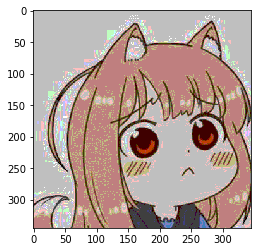

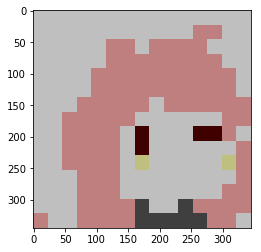

In [29]:


import numpy as np
import os
from PIL import Image,ImageFilter
import matplotlib.pyplot as plt
%matplotlib inline

def ssd(A,B):
    s = 0
    s = np.sum((A-B)**2) /(A.shape[0]*A.shape[1])
    return s

im = Image.open('./d7573a19ly1fjxc0mbta4j20el09rdg2.jpg').convert('RGB');
    
(width,height) = ( int(i/15) for i in im.size );
#  split the image to non-overlap patches.
print('patch size:',width,height)

img_patches = blockwise_view(np.array(im,dtype=np.uint8),(width,height,3),require_aligned_blocks=False)

img_patches = img_patches.squeeze();

bins = np.linspace(0, 255, num=5, endpoint=True, retstep=False, dtype=np.uint8) 

print('bins',bins)    

img_patches_idx = np.digitize(img_patches, bins)

img_patches = bins[img_patches_idx-1]

print(np.max(img_patches))

print(img_patches.shape);

print('all patches:',img_patches.shape)

# patterns
base_dir = '/Users/nantu/Downloads/patterns/';
patternx = [];

for root,dirs,files in os.walk(base_dir):
#     for i in range(len(files)):
        patternx = files
            
pattern = [os.path.join(base_dir,i) for i in patternx];

np_pattern = np.zeros((len(pattern),width,height,3));

for i in range(len(pattern)):
    im_tmp = Image.open(pattern[i]).convert('RGB')
    np_pattern[i,:,:,:] = np.array(im_tmp.resize((width,height)).filter(ImageFilter.FIND_EDGES))
    
print('np size:',np_pattern.shape)
final_shape = np.zeros(img_patches.shape)

for i in range(img_patches.shape[0]):
    for j in range(img_patches.shape[1]):
        im_patch = img_patches[i][j];
        dic = {}
        for k in range(im_patch.shape[0]):
            for kx in range(im_patch.shape[1]):
                tp = tuple((im_patch[k][kx][0],im_patch[k][kx][1],im_patch[k][kx][2]));
                if tp in dic:
                    dic[tp] = dic[tp] + 1
                else:
                    dic[tp] = 1
                    
        # count the most 
        rrr = tuple()
        xxx = 0
        for k,v in dic.items():
            if v > xxx:
                xxx = v;
                rrr = k
        final_shape[i,j,:,:,0].fill(rrr[0]);
        final_shape[i,j,:,:,1].fill(rrr[1]);
        final_shape[i,j,:,:,2].fill(rrr[2]);
    
original_image = img_patches.transpose(0,2,1,3,4).reshape((height*img_patches.shape[0],
                                                           width*img_patches.shape[0],3));

final_image = final_shape.transpose(0,2,1,3,4).reshape((height*img_patches.shape[0],
                                                           width*img_patches.shape[0],3))

plt.imshow(np.uint8(original_image))
plt.show()

# print(np.max(final_image))
plt.imshow(np.uint8(final_image))
plt.show()